<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/parameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#参考 : https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_cv.py

https://optuna.readthedocs.io/en/stable/index.html

In [5]:
!cp -r '/content/drive/MyDrive/Movies/data/mojo_japan/' '/content/'

!cp -r '/content/drive/MyDrive/Movies/data/metadata_filmarks/' '/content/'

In [6]:
!pip install japanize_matplotlib
import pandas as pd
import codecs 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

import warnings

import os
from tqdm import tqdm
import gc

In [7]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import r2_score
#r2_score(y_true, y_pred)

In [9]:
#import optuna
#from optuna.integration import lightgbm_tuner
!pip install optuna
import optuna.integration.lightgbm as lgb

     |████████████████████████████████| 286kB 6.7MB/s 
     |████████████████████████████████| 163kB 10.6MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 481kB 11.6MB/s 
     |████████████████████████████████| 112kB 14.0MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=f755545e03239a773c44f0a1cbc2577872f5e7fa3be0bbd8e4e96270791f2aad
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=97bfc6b3dfa233583e66b4a2014f7579fdf1605c006526ac8852514eb47a419a
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha

In [10]:
path = '/content/drive/MyDrive/Movies/preprocessed/'

In [11]:
def read_data(path, encode_type):
  
  with codecs.open(path, "r", encode_type, "ignore") as file:
    output = pd.read_csv(file, delimiter=",")
      
  return output

In [12]:
train = read_data(path+'train_2016-2018.csv', encode_type='utf-8')
test = read_data(path+'test_2019.csv', encode_type='utf-8')

train = train.loc[train['Title'].drop_duplicates(keep='first').index]

In [13]:
train.shape

(512, 9017)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



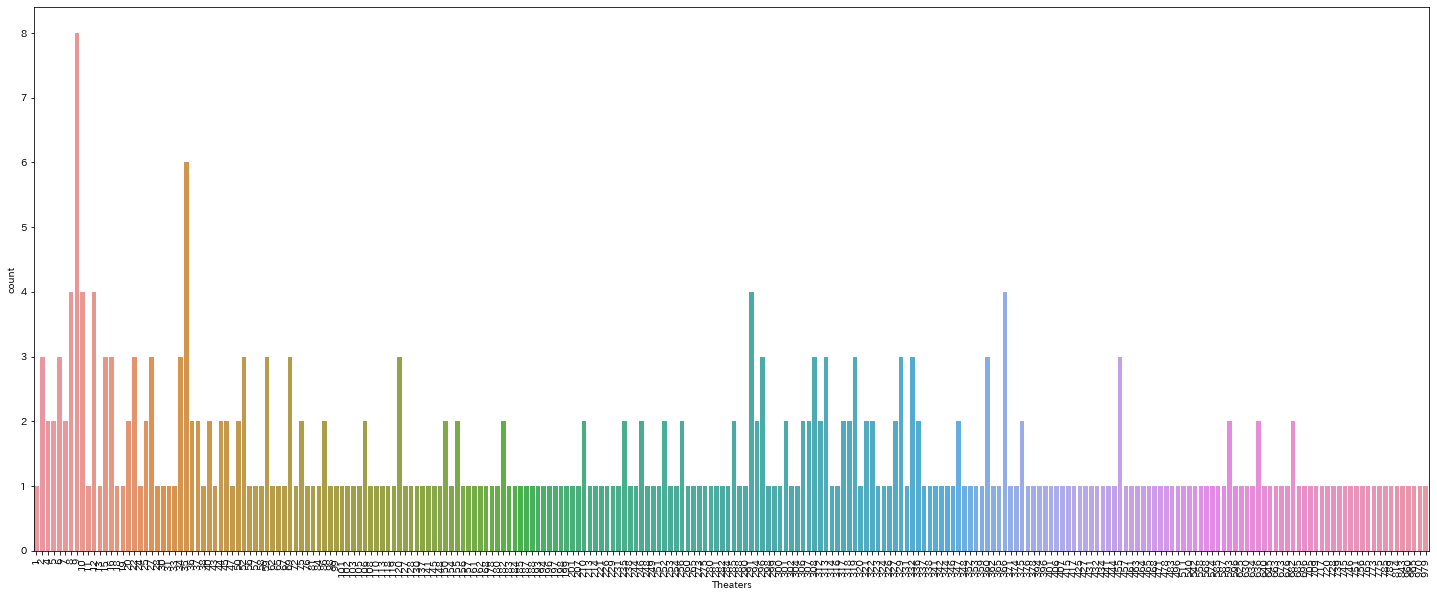

- of number : 334
mean of Theaters:262
(512, 9017) (168, 9017)


In [15]:
def preprocess_Theaters(input_df:pd.DataFrame)->pd.DataFrame:
  output_df = input_df.copy()
  plt.figure(figsize=(25,10))
  sns.countplot(input_df.loc[input_df['Theaters']!='-', 'Theaters'].astype(int).sort_values())
  plt.xticks(rotation=90)
  plt.show()
  print('- of number : {}'.format(input_df[input_df['Theaters']=='-'].__len__()))
  mean_ = input_df.loc[input_df['Theaters']!='-','Theaters'].astype(int).mean()

  print(f'mean of Theaters:{int(mean_)}')
  output_df['Theaters'] = output_df['Theaters'].replace('-', mean_).astype(int)

  return output_df

def lable_encoding(input_df:pd.DataFrame, cat_cols:list)->pd.DataFrame:
  output_df = input_df.copy()
  # カテゴリ変数は出現順にLabelEncoding
  for c in cat_cols:
    _dict = {j:i for i,j in enumerate(input_df[c].unique())}
    output_df[c] = input_df[c].map(_dict)
    
  return output_df

#上映館数の前処理
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = preprocess_Theaters(data)

cols=['Country', 'Opening_Day']
data = lable_encoding(data, cols)

train = data[0:len(train)]
test = data[len(train):]


print(train.shape, test.shape)

In [16]:
#アルゴリズムの方で分岐しているから必要ないかもしれない特徴量

def make_describe_col(input_df:pd.DataFrame, col:str):
  output_df = input_df.copy() 
  p_25 = output_df[col].describe()['25%']
  p_50 = output_df[col].describe()['50%']
  p_75 = output_df[col].describe()['75%']

  # 25%未満
  output_df[f'{col}_[x<25%]'] = output_df[col].apply(
      lambda x: 1 if x<p_25 else 0 
  )
  # 25%以上 50%未満
  output_df[f'{col}_[25<=x<50%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_25 and x<p_50 else 0 
  )
  # 50%以上 75%未満
  output_df[f'{col}_[50<=x<75%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_50 and x<p_75 else 0 
  )
  # 75%以上
  output_df[f'{col}_[75%<x]'] = output_df[col].apply(
      lambda x: 1 if x>=p_75 else 0 
  )

  return output_df

train = make_describe_col(train, 'Theaters')
train = make_describe_col(train, 'Time')

test = make_describe_col(test, 'Theaters')
test = make_describe_col(test, 'Time')

#正規化

In [17]:
from sklearn import preprocessing

def normalization(df:pd.DataFrame, cols:list):
  output_df = df.copy()

  ss = preprocessing.StandardScaler()
  output_df[cols]= ss.fit_transform(output_df[cols])
  output_df[cols].add_suffix('_ss')

  return output_df 

In [18]:
use_columns = [
        'レビュー数',
        '平均スコア', 
        'Gross', 
        'Total Gross',
        'Theaters' ]

train = normalization(train, use_columns)
test = normalization(test, use_columns)

In [19]:
#レビュー，平均スコアを含める場合
#drop_cols=['Title','Title(ja)','directors','writers','casts']

#----------------------------------------------------------------
#レビュー，平均スコアを含めない場合
drop_cols=['Title','Title(ja)','directors','writers','casts','レビュー数','平均スコア']

In [20]:
#Total Grossを予測する場合
train_features = train.drop(drop_cols+['Gross'], axis=1) #'レビュー数','平均スコア'], axis=1)

#test_features = test.drop(drop_cols+['Gross'], axis=1)     #'レビュー数','平均スコア'], axis=1)


In [21]:
X = train_features.drop('Total Gross', axis=1)
y = train_features['Total Gross']

#対数スケールに変換
y = np.log1p(y)

dtrain = lgb.Dataset(X, y)

#train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.2, random_state=42)
#dtrain = lgb.Dataset(train_X, train_y)
#dvalid = lgb.Dataset(valid_X, valid_y)

In [22]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'verbosity':-1,
    "boosting_type": "gbdt",
}

In [23]:
tuner = lgb.LightGBMTunerCV(
        params, dtrain, 
        verbose_eval=1000, 
        early_stopping_rounds=100, 
        folds=KFold(n_splits=5),
    )

tuner.run()

[I 2021-01-20 14:35:39,338] A new study created in memory with name: no-name-5e022650-d9f4-431e-adde-db692e017b0a
min_data_in_leaf, val_score: 0.515259: 100%|##########| 5/5 [00:01<00:00,  2.88it/s]


In [24]:
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")

for key, value in best_params.items():
        print("    {}: {}".format(key, value))

Best score: 0.5152588862203789
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 6.1804862101241e-08, 'lambda_l2': 7.903725426067618, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.40788062985198775, 'bagging_freq': 2, 'min_child_samples': 5}
  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 6.1804862101241e-08
    lambda_l2: 7.903725426067618
    num_leaves: 2
    feature_fraction: 0.4
    bagging_fraction: 0.40788062985198775
    bagging_freq: 2
    min_child_samples: 5


In [25]:
best_params

{'bagging_fraction': 0.40788062985198775,
 'bagging_freq': 2,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.4,
 'feature_pre_filter': False,
 'lambda_l1': 6.1804862101241e-08,
 'lambda_l2': 7.903725426067618,
 'metric': 'rmse',
 'min_child_samples': 5,
 'num_leaves': 2,
 'objective': 'regression',
 'verbosity': -1}

#レビューデータを含める場合

In [26]:
review = pd.read_csv('/content/drive/MyDrive/Movies/preprocessed/keiyousi_2016-2019.csv')
review_ = review.drop_duplicates()
review_ = review_.drop(['Title(ja)','title_url'], axis=1)
train = train.merge(review_, how='left', on='Title')
#test = test.merge(review_, how='left', on='Title')

train_features = train.drop(drop_cols+['Gross'], axis=1)

X = train_features.drop('Total Gross', axis=1)
y = train_features['Total Gross']
#対数スケールに変換
y = np.log1p(y)

dtrain = lgb.Dataset(X, y)

In [27]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'verbosity':-1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
        params, dtrain, 
        verbose_eval=1000, 
        early_stopping_rounds=100, 
        folds=KFold(n_splits=5),
    )

tuner.run()

[I 2021-01-20 14:39:19,957] A new study created in memory with name: no-name-af425b8f-b5eb-40de-8a07-be0a1008ad5a
min_data_in_leaf, val_score: 0.521890: 100%|##########| 5/5 [00:05<00:00,  1.19s/it]


In [28]:
print("Best score:", tuner.best_score)
best_params_with_reviews = tuner.best_params
print("Best params:", best_params_with_reviews)
print("  Params: ")

for key, value in best_params_with_reviews.items():
        print("    {}: {}".format(key, value))

Best score: 0.5218897248467763
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.20327967123657972, 'lambda_l2': 1.1235700835443209e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.8447890107304752, 'bagging_freq': 4, 'min_child_samples': 100}
  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.20327967123657972
    lambda_l2: 1.1235700835443209e-05
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.8447890107304752
    bagging_freq: 4
    min_child_samples: 100


#タイトルデータを含める場合

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (5628) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



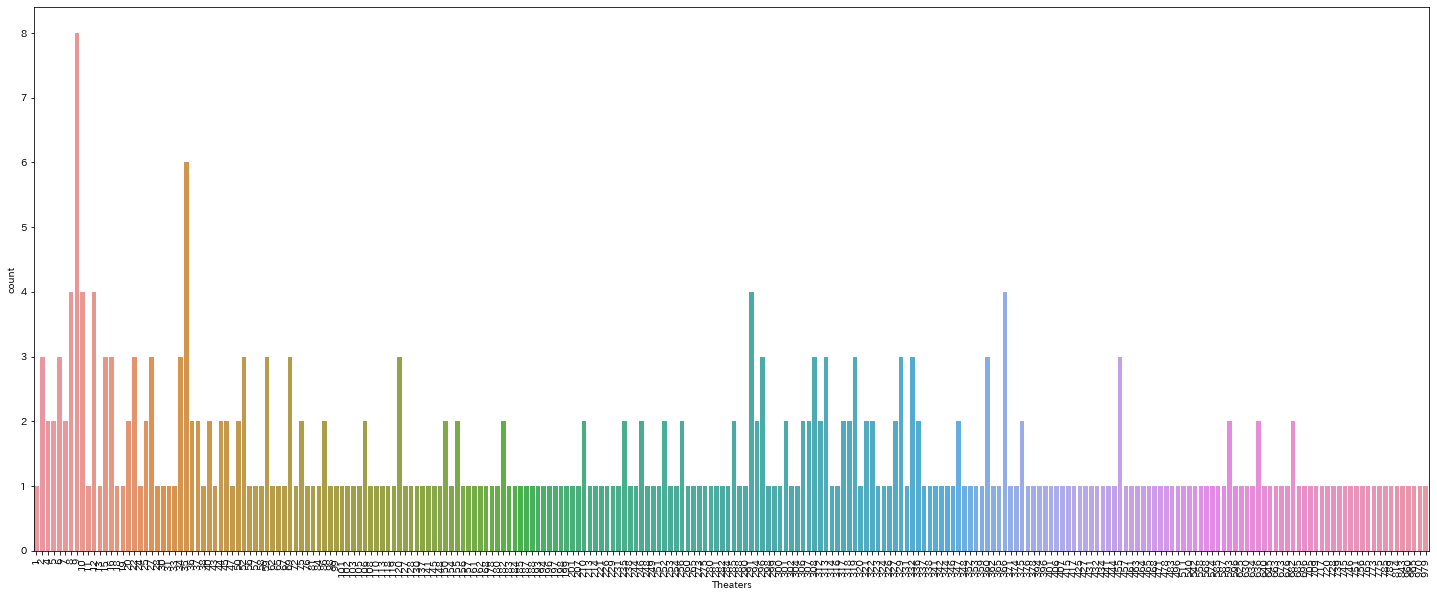

- of number : 335
mean of Theaters:262
(514, 9063) (167, 9063)


In [31]:
train = read_data(path+'train_2016-2018_title.csv', encode_type='utf-8')
test = read_data(path+'test_2019_title.csv', encode_type='utf-8')
train = train.loc[train['Title'].drop_duplicates(keep='first').index]

#上映館数の前処理
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = preprocess_Theaters(data)
cols=['Country', 'Opening_Day']
data = lable_encoding(data, cols)
train = data[0:len(train)]
test = data[len(train):]
print(train.shape, test.shape)


train = make_describe_col(train, 'Theaters')
train = make_describe_col(train, 'Time')

use_columns = [
        'レビュー数',
        '平均スコア', 
        'Gross', 
        'Total Gross',
        'Theaters' ]

train = normalization(train, use_columns)
test = normalization(test, use_columns)

In [32]:
#review = pd.read_csv('/content/drive/MyDrive/Movies/preprocessed/keiyousi_2016-2019.csv')
#review_ = review.drop_duplicates()
#review_ = review_.drop(['Title(ja)','title_url'], axis=1)
#train = train.merge(review_, how='left', on='Title')
#test = test.merge(review_, how='left', on='Title')

train_features = train.drop(drop_cols+['Gross'], axis=1)

X = train_features.drop('Total Gross', axis=1)
y = train_features['Total Gross']
#対数スケールに変換
y = np.log1p(y)

dtrain = lgb.Dataset(X, y)

#parameter setting----
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'verbosity':-1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
        params, dtrain, 
        verbose_eval=1000, 
        early_stopping_rounds=100, 
        folds=KFold(n_splits=5),
    )

tuner.run()

[I 2021-01-20 14:45:40,214] A new study created in memory with name: no-name-4191ea1c-01ec-44f1-aa07-b9836e97517b

feature_fraction, val_score: 0.576043:  14%|#4        | 1/7 [00:00<00:02,  2.83it/s][I 2021-01-20 14:45:40,582] Trial 0 finished with value: 0.5760432373422791 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.5760432373422791.

feature_fraction, val_score: 0.559198:  29%|##8       | 2/7 [00:00<00:01,  2.87it/s][I 2021-01-20 14:45:40,917] Trial 1 finished with value: 0.5591983129917596 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.5591983129917596.

feature_fraction, val_score: 0.559198:  43%|####2     | 3/7 [00:01<00:01,  2.80it/s][I 2021-01-20 14:45:41,294] Trial 2 finished with value: 0.5764146292654602 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.5591983129917596.

feature_fraction, val_score: 0.559198:  57%|#####7    | 4/7 [00:01<00:01,  2.72it/s][I 2021-01-20 14:45:41,685] Trial 3 finished 

In [33]:
print("Best score:", tuner.best_score)
best_params_with_title = tuner.best_params
print("Best params:", best_params_with_title)
print("  Params: ")

for key, value in best_params_with_title.items():
        print("    {}: {}".format(key, value))

Best score: 0.5530960273647502
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.00020999170826448098, 'lambda_l2': 0.6120350098326663, 'num_leaves': 31, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.00020999170826448098
    lambda_l2: 0.6120350098326663
    num_leaves: 31
    feature_fraction: 0.44800000000000006
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [34]:
review = pd.read_csv('/content/drive/MyDrive/Movies/preprocessed/keiyousi_2016-2019.csv')
review_ = review.drop_duplicates()
review_ = review_.drop(['Title(ja)','title_url'], axis=1)
train = train.merge(review_, how='left', on='Title')
test = test.merge(review_, how='left', on='Title')

train_features = train.drop(drop_cols+['Gross'], axis=1)

X = train_features.drop('Total Gross', axis=1)
y = train_features['Total Gross']
#対数スケールに変換
y = np.log1p(y)

dtrain = lgb.Dataset(X, y)

#parameter setting----
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'verbosity':-1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
        params, dtrain, 
        verbose_eval=1000, 
        early_stopping_rounds=100, 
        folds=KFold(n_splits=5),
    )

tuner.run()

[I 2021-01-20 14:47:23,397] A new study created in memory with name: no-name-b7036e0d-469f-44a2-a457-22ae0d293396

feature_fraction, val_score: 0.593998:  14%|#4        | 1/7 [00:01<00:07,  1.26s/it][I 2021-01-20 14:47:24,667] Trial 0 finished with value: 0.5939981328064949 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.5939981328064949.

feature_fraction, val_score: 0.593998:  29%|##8       | 2/7 [00:02<00:06,  1.28s/it][I 2021-01-20 14:47:25,991] Trial 1 finished with value: 0.6045513563138658 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5939981328064949.

feature_fraction, val_score: 0.593845:  43%|####2     | 3/7 [00:03<00:04,  1.21s/it][I 2021-01-20 14:47:27,051] Trial 2 finished with value: 0.5938448456156009 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.5938448456156009.

feature_fraction, val_score: 0.593845:  57%|#####7    | 4/7 [00:05<00:04,  1.43s/it][I 2021-01-20 14:47:28,988] Trial 3 finished 

In [35]:
print("Best score:", tuner.best_score)
best_params_with_title_reviews = tuner.best_params
print("Best params:", best_params_with_title_reviews)
print("  Params: ")

for key, value in best_params_with_title_reviews.items():
        print("    {}: {}".format(key, value))

Best score: 0.5673921710984623
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.4966724740282267e-07, 'lambda_l2': 0.0004091598015527114, 'num_leaves': 31, 'feature_fraction': 0.516, 'bagging_fraction': 0.526761834326902, 'bagging_freq': 4, 'min_child_samples': 10}
  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.4966724740282267e-07
    lambda_l2: 0.0004091598015527114
    num_leaves: 31
    feature_fraction: 0.516
    bagging_fraction: 0.526761834326902
    bagging_freq: 4
    min_child_samples: 10


In [36]:
#レビュー，平均スコアを含める場合
drop_cols=['Title','Title(ja)','directors','writers','casts']

train_features = train.drop(drop_cols+['Gross'], axis=1)

X = train_features.drop('Total Gross', axis=1)
y = train_features['Total Gross']
#対数スケールに変換
y = np.log1p(y)

dtrain = lgb.Dataset(X, y)

#parameter setting----
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'verbosity':-1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
        params, dtrain, 
        verbose_eval=1000, 
        early_stopping_rounds=100, 
        folds=KFold(n_splits=5),
    )

tuner.run()

[I 2021-01-20 14:50:39,777] A new study created in memory with name: no-name-6d9e983f-6237-47af-9c5b-85662a68f766

feature_fraction, val_score: 0.509317:  14%|#4        | 1/7 [00:01<00:07,  1.27s/it][I 2021-01-20 14:50:41,058] Trial 0 finished with value: 0.5093173869939356 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.5093173869939356.

feature_fraction, val_score: 0.508519:  29%|##8       | 2/7 [00:03<00:07,  1.48s/it][I 2021-01-20 14:50:43,048] Trial 1 finished with value: 0.5085185397679755 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.5085185397679755.

feature_fraction, val_score: 0.508519:  43%|####2     | 3/7 [00:05<00:06,  1.58s/it][I 2021-01-20 14:50:44,865] Trial 2 finished with value: 0.5116812577258081 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.5085185397679755.

feature_fraction, val_score: 0.508519:  57%|#####7    | 4/7 [00:06<00:04,  1.55s/it][I 2021-01-20 14:50:46,326] Tr

In [37]:
print("Best score:", tuner.best_score)
best_params_with_title_reviews_leakcols = tuner.best_params
print("Best params:", best_params_with_title_reviews_leakcols)
print("  Params: ")

for key, value in best_params_with_title_reviews_leakcols.items():
        print("    {}: {}".format(key, value))

Best score: 0.48525189089537013
Best params: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 7, 'feature_fraction': 0.716, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}
  Params: 
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 7
    feature_fraction: 0.716
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [42]:
best_params['data'] = 'baseline'
best_params_with_reviews['data'] = 'baseline_with_reviews'
best_params_with_title['data'] = 'best_params_with_title'
best_params_with_title_reviews['data'] = 'best_params_with_title_reviews'
best_params_with_title_reviews_leakcols['data'] = 'best_params_with_title_reviews_leakcols'


all_best_params = pd.DataFrame(
[best_params,
best_params_with_reviews,
best_params_with_title,
best_params_with_title_reviews,
best_params_with_title_reviews_leakcols
 ])

In [43]:
all_best_params

,objective,metric,verbosity,boosting_type,feature_pre_filter,lambda_l1,lambda_l2,num_leaves,feature_fraction,bagging_fraction,bagging_freq,min_child_samples,data
0,regression,rmse,-1,gbdt,False,6.180486e-08,7.903725,2,0.400,0.407881,2,5,baseline
1,regression,rmse,-1,gbdt,False,2.032797e-01,0.000011,31,0.400,0.844789,4,100,baseline_with_reviews
2,regression,rmse,-1,gbdt,False,2.099917e-04,0.612035,31,0.448,1.000000,0,20,best_params_with_title
3,regression,rmse,-1,gbdt,False,1.496672e-07,0.000409,31,0.516,0.526762,4,10,best_params_with_title_reviews
4,regression,rmse,-1,gbdt,False,0.000000e+00,0.000000,7,0.716,1.000000,0,10,best_params_with_title_reviews_leakcols


In [44]:
all_best_params.to_csv(
    '/content/drive/MyDrive/Movies/result/best_params.csv'
    ,index=False)